In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numba import jit
from scipy.integrate import solve_ivp
from ipywidgets import *
from matplotlib.widgets import Button

In [2]:
def ssa(init_m,init_d,g1,g2,k1,k2,kappa,T):
    MAX=200000
    sub_m=np.zeros([T+1])
    sub_d=np.zeros([T+1])
    sub_m[0]=init_m
    sub_d[0]=init_d
    v=np.array([[0, 1],[0, 1],[0, -1],[1, 0],[-1,0]])   #reaction vectors growth,diff,death
    
    m=np.zeros(MAX)   #mother cell
    d=np.zeros(MAX)   #daughter cell
    t_x=np.zeros(MAX) #reaction time

    m[0]=init_m
    d[0]=init_d
    j=0     
    idx=0
    while t_x[j]<T:
        eta=(1+(m[j]/K1)**q)**(-1)
        gamma=(1+(d[j]/K2)**q)**(-1)
        a=np.array([g2*gamma*d[j], g1*gamma*(1-eta)*m[j], k2*kappa*d[j], g1*gamma*eta*m[j],k1*kappa*m[j]] )
        cumsum_a=np.cumsum(a)
        sum_a=np.sum(a)
        epsilon=np.random.uniform(0,1,2)
        if sum_a==0:
            [m[j+1],d[j+1]]=[m[j],d[j]]
            tau=1
        else:
            tau=(np.log(1./epsilon[1]))/sum_a
            l=np.min(np.where(epsilon[0]*sum_a<cumsum_a))
            [m[j+1],d[j+1]]=[m[j],d[j]]+v[l]
        t_x[j+1]=t_x[j]+tau
        if t_x[j+1]>idx+1:
            while idx<t_x[j+1]:
                idx+=1
                if idx<=T:
                    sub_m[idx]=m[j]
                    sub_d[idx]=d[j]
        j+=1
    return m[:j],d[:j],t_x[:j]#sub_m, sub_d 

def BSGC(t,z,K1,K2,k1,k2,g1,g2,q):
    eta=(1+(z[0]/K1)**q)**(-1)
    gamma=(1+(z[1]/K2)**q)**(-1)
    N1=g1*eta*gamma*z[0]-k1*z[0]
    N2=(g2*z[1]+g1*(1-eta)*z[0])*gamma-k2*z[1]
    return [N1, N2]


<IPython.core.display.Javascript object>


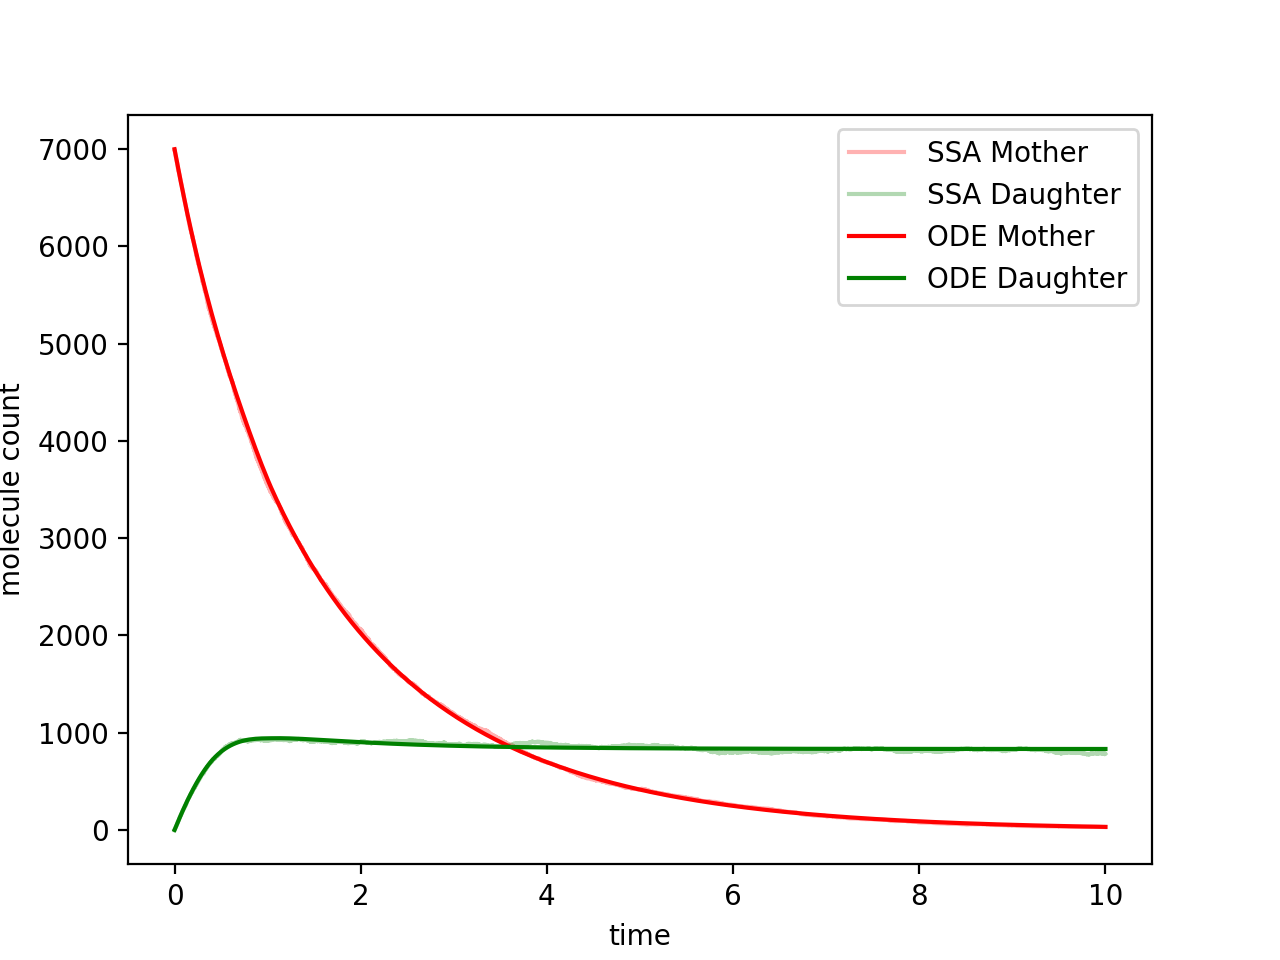

interactive(children=(FloatSlider(value=0.5, description='$g_1$', max=1.0, readout_format='1.2f'), FloatSlider…

In [12]:
%matplotlib notebook
#stochastic model parameters
init_m=7000
init_d=0
g1_init=g2_init=0.5    #### 
k1_init=k2_init=0.5    ####
kappa_init=1

#ODE model hyeprparameters
q=5
K1=5000
K2=1000

T=10

fig, ax = plt.subplots()
plt.subplots_adjust(left=0.1, bottom=0.1)
t = np.linspace(0, T, 300)
#m,d=ssa(init_m,init_d,g1_init,g2_init,k1_init,k2_init,kappa_init,T)
#l1, = plt.plot(range(T+1),m,color='r',alpha=0.3)
#l2, = plt.plot(range(T+1),d,color='g',alpha=0.3)
m,d,t_x=ssa(init_m,init_d,g1_init,g2_init,k1_init,k2_init,kappa_init,T)
l1, = plt.plot(t_x,m,color='r',alpha=0.3,label='SSA Mother')
l2, = plt.plot(t_x,d,color='g',alpha=0.3,label='SSA Daughter')

sol = solve_ivp(lambda t, z: BSGC(t, z, K1,K2,k1_init,k2_init,g1_init,g2_init,q), [0, T], [init_m, init_d],dense_output=True)
z = sol.sol(t)
l3, = plt.plot(t,z[0].T,'r',label='ODE Mother')
l4, = plt.plot(t,z[1].T,'g',label='ODE Daughter')
plt.legend()
plt.xlabel('time')
plt.ylabel('molecule count')

g1=widgets.FloatSlider(description=r'$g_1$',value=g1_init,min=0.,max=1.0,step=0.1,orientation='horizontal',readout_format='1.2f')
g2=widgets.FloatSlider(description=r'$g_2$',value=g2_init,min=0.,max=1.0,step=0.1,orientation='horizontal',readout_format='1.2f')
k1=widgets.FloatSlider(description=r'$k_1$',value=k1_init,min=0.,max=1.0,step=0.1,orientation='horizontal',readout_format='1.2f')
k2=widgets.FloatSlider(description=r'$k_2$',value=k2_init,min=0.,max=1.0,step=0.1,orientation='horizontal',readout_format='1.2f')
kappa=widgets.FloatSlider(description=r'$\kappa$',value=kappa_init,min=0.,max=1.0,step=0.1,orientation='horizontal',readout_format='1.2f')

def update(g1=g1,g2=g2,k1=k1,k2=k2,kappa=kappa):
    #m,d=ssa(init_m,init_d,g1,g2,k1,k2,kappa,T)
    m,d,t_x=ssa(init_m,init_d,g1,g2,k1,k2,kappa,T)
    sol = solve_ivp(lambda t, z: BSGC(t, z, K1,K2,k1,k2,g1,g2,q), [0, T], [init_m, init_d],dense_output=True)
    z = sol.sol(t)
    l1.set_data(t_x,m)
    l2.set_data(t_x,d)
    #l1.set_ydata(m)
    #l2.set_ydata(d)
    l3.set_ydata(z[0].T)
    l4.set_ydata(z[1].T)
    fig.canvas.draw_idle()

interact(update);

Keep $\kappa$ at 1 for BSGC.